In [53]:
# Uncomment the following lines if you are using Windows!
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql.functions import abs as abs_col
from pyspark.sql.functions import *

from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

appName = "Big Data Analytics"
master = "local"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

# Create Spark Context with the new configurations rather than relying on the default one
sc = SparkContext.getOrCreate(conf=conf)

spark = (
    SparkSession.builder
    .appName("Big Data Analytics")
    .master("local")
    .config("spark.driver.host", '127.0.0.1')
    .getOrCreate()
)

In [54]:
# Ingest data into Postgres
db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db passwor
db_properties['password']= "1234"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "fifa.players"

In [55]:
df_read = spark.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

df_read.show(10)

+---------+--------------------+-----------------+--------------------+----------------+-------+---------+---------+--------+---+----------+---------+---------+------------+-------------------+--------------------+------------+-------------+------------------+----------------+-----------+-------------------------+--------------+----------------+--------------+---------------+--------------------+--------------+---------+-----------+------------------------+-------------+----------------+---------+------------------+--------------------+--------------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-

In [56]:
df_read.printSchema()

root
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: date (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: double (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: integer (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: date (nullable = true)
 |-- club_contract_valid_until: integer (nullable = true)
 |-- nationality_id: integer (nullable = true)
 

## Drop Unused Columns

In [57]:
columns_to_drop = ['sofifa_id', 'player_url', 'short_name', 'long_name', 'player_face_url', 'club_logo_url', 'club_flag_url', 'nation_logo_url', 'nation_flag_url', 'UID', 'Year'] # Identifiers and URLs
columns_to_drop = columns_to_drop + ['club_team_id', 'club_name', 'league_name', 'nationality_id', 'nationality_name', 'nation_team_id'] # Club and nation names
columns_to_drop = columns_to_drop + ['dob', 'club_joined', 'club_contract_valid_until', 'club_loaned_from'] # Personal Details
columns_to_drop = columns_to_drop + ['club_position', 'club_jersey_number', 'nation_position', 'nation_jersey_number', 'player_positions'] # Positional Details
columns_to_drop = columns_to_drop + ['real_face', 'player_tags', 'player_traits'] # Aesthetic Details
columns_to_drop = columns_to_drop + ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk'] # Derived Positional Details
df_dropped_unused= df_read.drop(*columns_to_drop)

In [58]:
df_dropped_unused.printSchema()

root
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- preferred_foot: string (nullable = true)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- international_reputation: integer (nullable = true)
 |-- work_rate: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- release_clause_eur: string (nullable = true)
 |-- pace: integer (nullable = true)
 |-- shooting: integer (nullable = true)
 |-- passing: integer (nullable = true)
 |-- dribbling: integer (nullable = true)
 |-- defending: integer (nullable = true)
 |-- physic: integer (nullable = true)
 |-- attacking_crossing: integer (nullable = true)
 |-- attacking_finishing: integer (nullable = true)
 |

In [59]:
df_dropped_unused.show(10)

+-------+---------+---------+--------+---+---------+---------+------------+--------------+---------+-----------+------------------------+-------------+----------------+------------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+-----------------+
|overall|potential|value_eur|wage_eur|age|height_cm|weight_kg|league_le

# Remove Null values

In [60]:
null_count = df_dropped_unused.select([count(when(col(c).isNull(), c)).alias(c) for c in df_dropped_unused.columns]).toPandas()
print(null_count.to_string())

# After looking at the null count, we figured there are five traits that Goal keepers do not have so we will have to do data imputation for that. 
# For columns like release_clause_eur, mentality composure and goalkeeping_speed, they have too many null counts so we will simply drop them.
df_dropped_unused = df_dropped_unused.drop('release_clause_eur', 'mentality_composure', 'goalkeeping_speed')


   overall  potential  value_eur  wage_eur  age  height_cm  weight_kg  league_level  preferred_foot  weak_foot  skill_moves  international_reputation  work_rate  body_type  release_clause_eur   pace  shooting  passing  dribbling  defending  physic  attacking_crossing  attacking_finishing  attacking_heading_accuracy  attacking_short_passing  attacking_volleys  skill_dribbling  skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  movement_acceleration  movement_sprint_speed  movement_agility  movement_reactions  movement_balance  power_shot_power  power_jumping  power_stamina  power_strength  power_long_shots  mentality_aggression  mentality_interceptions  mentality_positioning  mentality_vision  mentality_penalties  mentality_composure  defending_marking_awareness  defending_standing_tackle  defending_sliding_tackle  goalkeeping_diving  goalkeeping_handling  goalkeeping_kicking  goalkeeping_positioning  goalkeeping_reflexes  goalkeeping_speed
0        0          0    

In [61]:
df_dropped_unused.summary().show()

+-------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+--------------+------------------+------------------+------------------------+-------------+-----------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-------------------+--------------------------+-----------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------+---------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-----------------------+---------------------+------------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+----

In [62]:
# now we dropna of those columns that only have a small amount of null values
df_dropped_na = df_dropped_unused.dropna(subset = ['value_eur', 'wage_eur', 'league_level'])

## Data Imputation

In [63]:
# find the mean value for imputation needs
# Imputation for goalkeeper based on mean value
imputation_col = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
df_clone = df_dropped_na
for col in imputation_col:
    mean_value = df_dropped_na.select(mean(col)).collect()[0][0]
    df_clone = df_clone.na.fill(mean_value, subset=[col])


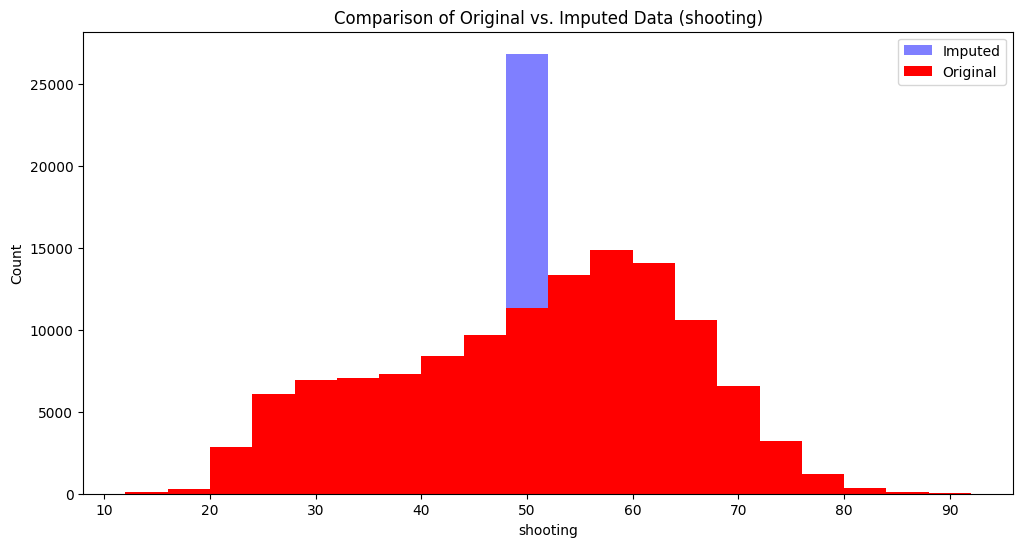

In [64]:
# Compute histogram for the original dataset
col = 'shooting'
histogram_original = df_dropped_na.select(col).rdd.flatMap(lambda x: x).histogram(20)
bin_edges_original = histogram_original[0]
bin_counts_original = histogram_original[1]

# Compute histogram for the imputed dataset
histogram_imputed = df_clone.select(col).rdd.flatMap(lambda x: x).histogram(20)
bin_edges_imputed = histogram_imputed[0]
bin_counts_imputed = histogram_imputed[1]

import matplotlib.pyplot as plt
import numpy as np

# Plotting both histograms for comparison
plt.figure(figsize=(12, 6))
# Histogram for imputed data
plt.bar(bin_edges_imputed[:-1], bin_counts_imputed, width=np.diff(bin_edges_imputed), color='blue', alpha=0.5, label='Imputed')
# Histogram for original data
plt.bar(bin_edges_original[:-1], bin_counts_original, width=np.diff(bin_edges_original), color='red', alpha=1, label='Original')


plt.xlabel(f'{col}')
plt.ylabel('Count')
plt.title(f'Comparison of Original vs. Imputed Data ({col})')
plt.legend()
plt.show()


In [65]:
df_clone.printSchema()

root
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- preferred_foot: string (nullable = true)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- international_reputation: integer (nullable = true)
 |-- work_rate: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- pace: integer (nullable = true)
 |-- shooting: integer (nullable = true)
 |-- passing: integer (nullable = true)
 |-- dribbling: integer (nullable = true)
 |-- defending: integer (nullable = true)
 |-- physic: integer (nullable = true)
 |-- attacking_crossing: integer (nullable = true)
 |-- attacking_finishing: integer (nullable = true)
 |-- attacking_heading_accuracy: integer (nullable =

# Type Casting

In [66]:
# Now we will cast string to integer for the following columns
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

string_cols = ['preferred_foot','work_rate', 'body_type']
for col in string_cols:
    print(df_clone.select(col).distinct().show())

indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in string_cols]
encoders = [OneHotEncoder(inputCol=column + "_index", outputCol=column + "_vec") for column in string_cols]

pipeline = Pipeline(stages=indexers + encoders)

df_transformed = pipeline.fit(df_clone).transform(df_clone)

+--------------+
|preferred_foot|
+--------------+
|          Left|
|         Right|
+--------------+

None
+-------------+
|    work_rate|
+-------------+
|Medium/Medium|
|  High/Medium|
|     Low/High|
|      Low/Low|
|    High/High|
|   Medium/Low|
|     High/Low|
|  Medium/High|
|   Low/Medium|
+-------------+

None
+----------------+
|       body_type|
+----------------+
|   Stocky (170-)|
|   Normal (185+)|
|     Lean (185+)|
|Normal (170-185)|
|     Lean (170-)|
|  Lean (170-185)|
|   Normal (170-)|
|   Stocky (185+)|
|Stocky (170-185)|
|          Unique|
+----------------+

None


In [67]:
df_transformed.select([c + "_index" for c in string_cols] + [c + "_vec" for c in string_cols]).show()

+--------------------+---------------+---------------+------------------+-------------+-------------+
|preferred_foot_index|work_rate_index|body_type_index|preferred_foot_vec|work_rate_vec|body_type_vec|
+--------------------+---------------+---------------+------------------+-------------+-------------+
|                 1.0|            3.0|            4.0|         (1,[],[])|(8,[3],[1.0])|(9,[4],[1.0])|
|                 0.0|            5.0|            2.0|     (1,[0],[1.0])|(8,[5],[1.0])|(9,[2],[1.0])|
|                 1.0|            5.0|            0.0|         (1,[],[])|(8,[5],[1.0])|(9,[0],[1.0])|
|                 0.0|            3.0|            2.0|     (1,[0],[1.0])|(8,[3],[1.0])|(9,[2],[1.0])|
|                 0.0|            0.0|            2.0|     (1,[0],[1.0])|(8,[0],[1.0])|(9,[2],[1.0])|
|                 0.0|            1.0|            4.0|     (1,[0],[1.0])|(8,[1],[1.0])|(9,[4],[1.0])|
|                 0.0|            1.0|            0.0|     (1,[0],[1.0])|(8,[1],[1

In [68]:
df_transformed.show(10)

+-------+---------+---------+--------+---+---------+---------+------------+--------------+---------+-----------+------------------------+-------------+----------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+--------------------+---------------+---------------+------------------+-------------+-------------+
|overall|potential|value_eur

## Data Scaling

+-------+------------------+------------------+
|summary|         value_eur|          wage_eur|
+-------+------------------+------------------+
|  count|            139789|            139789|
|   mean|2266186.2020616787|11149.539305667828|
| stddev| 5784416.866233048|22293.251897046266|
|    min|            1000.0|             500.0|
|    25%|          300000.0|            2000.0|
|    50%|          700000.0|            4000.0|
|    75%|         1800000.0|           10000.0|
|    max|            1.94E8|          575000.0|
+-------+------------------+------------------+



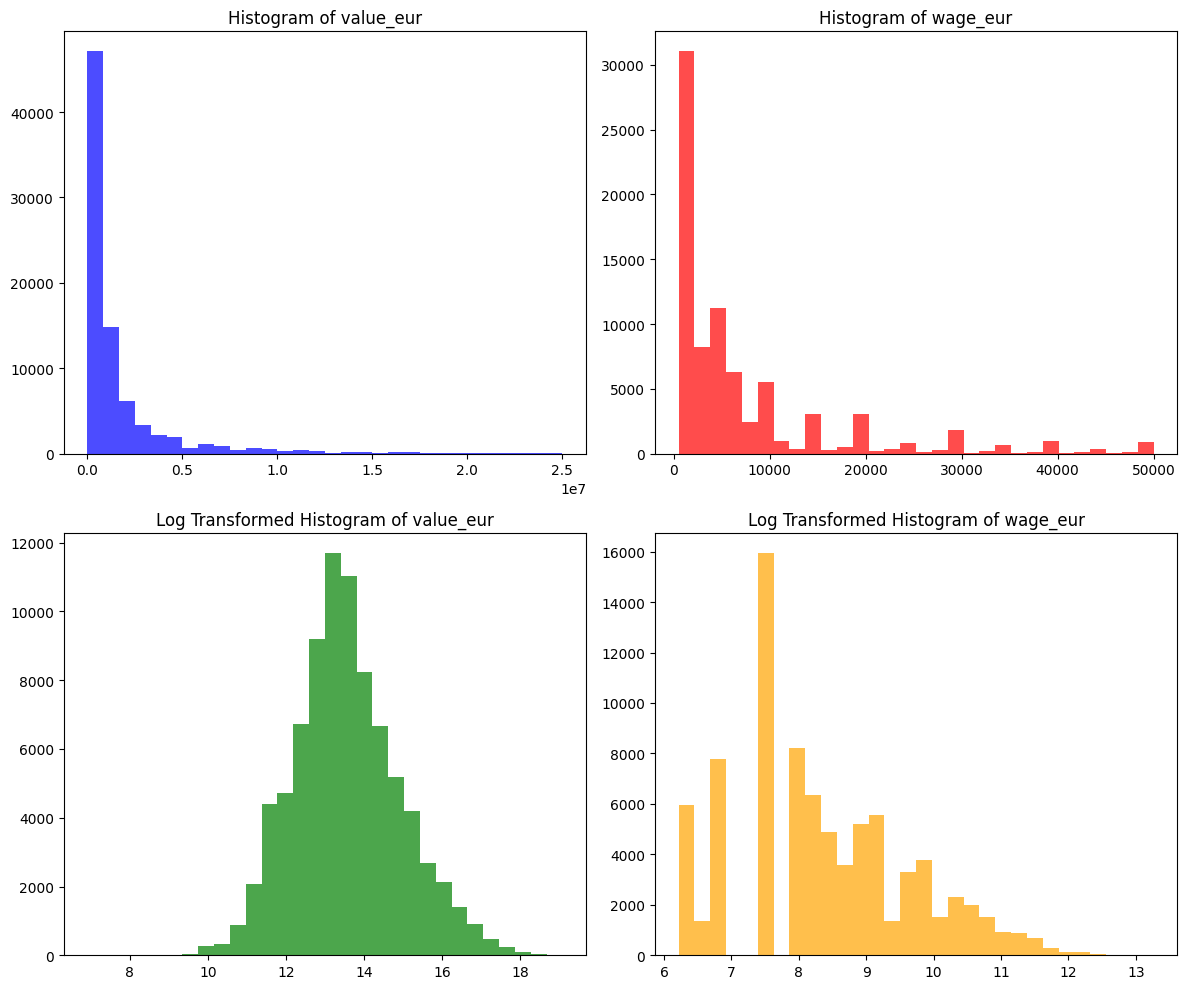

In [69]:
# before we vectorize the features, we will check if we need to do any scaling
df_transformed.select('value_eur', 'wage_eur').summary().show()
df = df_transformed
import matplotlib.pyplot as plt
import numpy as np

# Sampling a fraction of the data
sample_fraction = 0.6
sampled_data = df.select("value_eur", "wage_eur").sample(False, sample_fraction).toPandas()

# Adding logarithmic columns (log1p used to handle zero values)
sampled_data["log_value_eur"] = np.log1p(sampled_data["value_eur"])
sampled_data["log_wage_eur"] = np.log1p(sampled_data["wage_eur"])

# Plotting histograms
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

min_max_values = df.select(
    min("value_eur").alias("min_value_eur"),
    max("value_eur").alias("max_value_eur"),
    min("wage_eur").alias("min_wage_eur"),
    max("wage_eur").alias("max_wage_eur")
).collect()[0]

min_value_eur, max_value_eur, min_wage_eur, max_wage_eur = min_max_values


# Original Value Histograms
axes[0].hist(sampled_data["value_eur"], bins=30, range = [min_value_eur, 25000000], color='blue', alpha=0.7)
axes[0].set_title('Histogram of value_eur')

axes[1].hist(sampled_data["wage_eur"], bins=30, range = [min_wage_eur, 50000], color='red', alpha=0.7)
axes[1].set_title('Histogram of wage_eur')

# Log Transformed Histograms
axes[2].hist(sampled_data["log_value_eur"], bins=30, color='green', alpha=0.7)
axes[2].set_title('Log Transformed Histogram of value_eur')

axes[3].hist(sampled_data["log_wage_eur"], bins=30, color='orange', alpha=0.7)
axes[3].set_title('Log Transformed Histogram of wage_eur')

plt.tight_layout()
plt.show()


In [70]:
# After viewing the histograms, we will do log transformation for value_eur and wage_eur
df_scaled = df_transformed.withColumn("log_value_eur", log1p("value_eur"))
df_scaled = df_scaled.withColumn("log_wage_eur", log1p("wage_eur"))

df_scaled.show(10)

+-------+---------+---------+--------+---+---------+---------+------------+--------------+---------+-----------+------------------------+-------------+----------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+--------------------+---------------+---------------+------------------+-------------+-------------+------------------+----------

## Correlation Analysis

In [71]:
# Before we vectorize the features, we will perform a correlation analysis to see if there are any features that are highly correlated with each other
from pyspark.sql.functions import col, corr
import pandas as pd


numeric_features = df_scaled.drop('value_eur', 'wage_eur', 'preferred_foot', 'overall', 'work_rate', 'body_type', 'preferred_foot_index', 'work_rate_index', 'body_type_index', 'preferred_foot_vec', 'work_rate_vec', 'body_type_vec').columns
# Calculate correlation of each feature with the target variable
feature_correlation_with_target = {col: df_scaled.stat.corr(col, "overall") for col in numeric_features}

In [72]:
# Filter features based on a threshold

selected_features = []
for col, corr_value in feature_correlation_with_target.items():
    if __builtins__.abs(corr_value) > 0.4:
        selected_features.append(col)

print(f"Number of features selected: {len(selected_features)}")
print(f"Selected features: {selected_features}")
# Place holder for selected features
corr_matrix = pd.DataFrame(columns=selected_features, index=selected_features)

for col1 in selected_features:
    for col2 in selected_features:
        corr_value = df_scaled.select(corr(col1, col2)).collect()[0][0]
        corr_matrix.loc[col1, col2] = corr_value

corr_matrix

Number of features selected: 18
Selected features: ['potential', 'age', 'international_reputation', 'shooting', 'passing', 'dribbling', 'physic', 'attacking_short_passing', 'skill_curve', 'skill_long_passing', 'skill_ball_control', 'movement_reactions', 'power_shot_power', 'power_long_shots', 'mentality_aggression', 'mentality_vision', 'log_value_eur', 'log_wage_eur']


,potential,age,international_reputation,shooting,passing,dribbling,physic,attacking_short_passing,skill_curve,skill_long_passing,skill_ball_control,movement_reactions,power_shot_power,power_long_shots,mentality_aggression,mentality_vision,log_value_eur,log_wage_eur
potential,1.0,-0.195322,0.375412,0.300294,0.429026,0.455982,0.177959,0.3851,0.297244,0.342377,0.370877,0.540953,0.326838,0.275879,0.200731,0.359318,0.816284,0.57624
age,-0.195322,1.0,0.255026,0.215883,0.304561,0.152122,0.392482,0.136425,0.141889,0.182955,0.086863,0.453401,0.193093,0.15366,0.259538,0.188437,0.179044,0.309658
international_reputation,0.375412,0.255026,1.0,0.262525,0.339805,0.287066,0.1839,0.239944,0.226316,0.235992,0.213275,0.438811,0.242091,0.209543,0.173404,0.270008,0.45565,0.477092
shooting,0.300294,0.215883,0.262525,1.0,0.642128,0.764807,-0.000499,0.33579,0.557611,0.275685,0.424159,0.421457,0.674272,0.717761,-0.054162,0.618859,0.447064,0.401459
passing,0.429026,0.304561,0.339805,0.642128,1.0,0.81953,0.139702,0.607155,0.637966,0.674865,0.509507,0.583793,0.519141,0.565638,0.197593,0.750564,0.592472,0.525449
dribbling,0.455982,0.152122,0.287066,0.764807,0.81953,1.0,-0.041717,0.453993,0.596517,0.428968,0.529551,0.514556,0.510203,0.580766,0.007267,0.6667,0.574368,0.475426
physic,0.177959,0.392482,0.1839,-0.000499,0.139702,-0.041717,1.0,0.177852,0.008473,0.20302,0.095204,0.426375,0.180826,0.061614,0.616837,0.034463,0.374954,0.371248
attacking_short_passing,0.3851,0.136425,0.239944,0.33579,0.607155,0.453993,0.177852,1.0,0.769246,0.896723,0.908212,0.477777,0.695496,0.752863,0.610452,0.733272,0.517079,0.431689
skill_curve,0.297244,0.141889,0.226316,0.557611,0.637966,0.596517,0.008473,0.769246,1.0,0.705941,0.825549,0.409713,0.732572,0.828473,0.395307,0.749739,0.432169,0.387364
skill_long_passing,0.342377,0.182955,0.235992,0.275685,0.674865,0.428968,0.20302,0.896723,0.705941,1.0,0.787506,0.458443,0.61538,0.662839,0.589299,0.707293,0.474509,0.415213


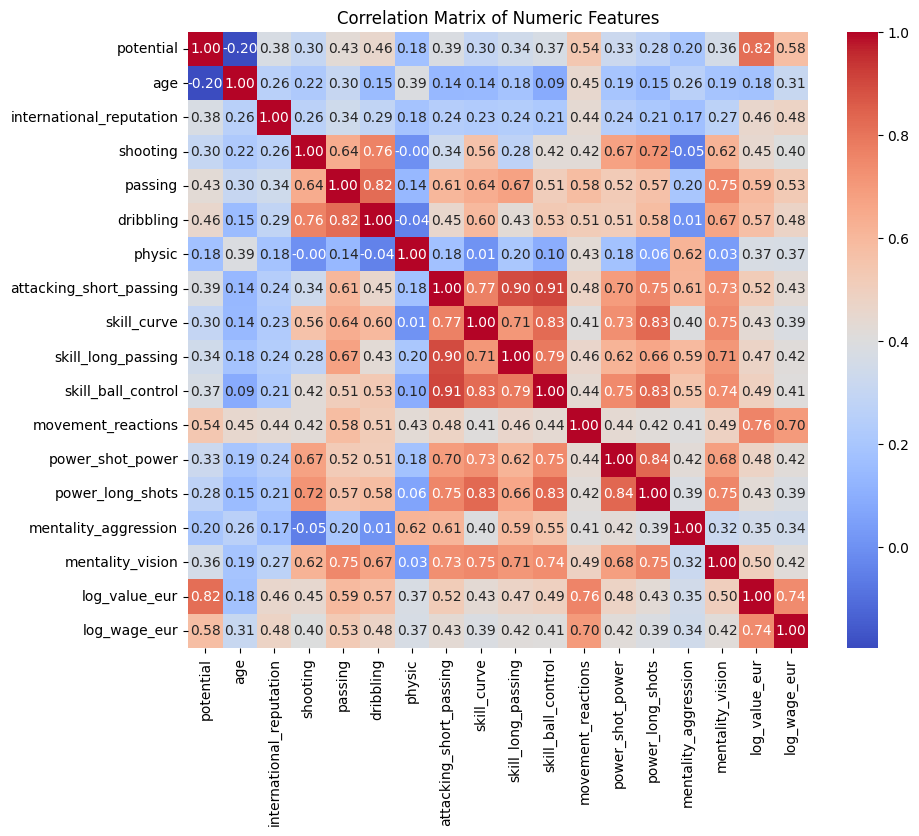

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = corr_matrix.astype(float)
# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [74]:
# Given the correlation matrix, we will drop the following columns
strong_corr_groups = [['shooting', 'dribbling', 'passing'], ['skill_long_passing', 'attacking_short_passing', 'skill_ball_control', 'skill_curve', 'power_shot_power', 'power_long_shots', 'mentality_vision']]

# We will keep one of the columns in each group
strongest_corr_with_target = 0
strongest_corr_col = ''
keep_col = []
for group in strong_corr_groups:
    for col in group:
        if __builtins__.abs(feature_correlation_with_target[col]) > strongest_corr_with_target:
            strongest_corr_with_target = __builtins__.abs(feature_correlation_with_target[col])
            strongest_corr_col = col
    keep_col.append(strongest_corr_col)
    strongest_corr_with_target = 0
print(f"Selected columns: {keep_col}")

dropped_cols = []
for group in strong_corr_groups:
    for col in group:
        if col not in keep_col:
            dropped_cols.append(col)
print(f"Dropped columns: {dropped_cols}")

df_scaled = df_scaled.drop(*dropped_cols)
print(df_scaled.columns)

Selected columns: ['passing', 'attacking_short_passing']
Dropped columns: ['shooting', 'dribbling', 'skill_long_passing', 'skill_ball_control', 'skill_curve', 'power_shot_power', 'power_long_shots', 'mentality_vision']
['overall', 'potential', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg', 'league_level', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'pace', 'passing', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_fk_accuracy', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_jumping', 'power_stamina', 'power_strength', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_penalties', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goa

## Remove Outliers

In [75]:
df_scaled.show(5)

+-------+---------+---------+--------+---+---------+---------+------------+--------------+---------+-----------+------------------------+-------------+----------------+----+-------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------------+---------------------+---------------------+----------------+------------------+----------------+-------------+-------------+--------------+--------------------+-----------------------+---------------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+--------------------+---------------+---------------+------------------+-------------+-------------+------------------+------------------+
|overall|potential|value_eur|wage_eur|age|height_cm|weight_kg|league_level|preferred_foot|weak_foot|skill_move

In [76]:
from pyspark.sql import functions as F
from functools import reduce

def find_outliers(df):
    # Assuming df.columns are all numeric. If not, filter non-numeric columns first.
    numeric_columns = df.columns

    print("Starting outlier detection...")
    outlier_flags = []

    for col in numeric_columns:
        print(f"Processing column: {col}")
        Q1, Q3 = df.approxQuantile(col, [0.25, 0.75], relativeError=0)
        IQR = Q3 - Q1

        less_Q1 = Q1 - 1.5 * IQR
        more_Q3 = Q3 + 1.5 * IQR

        outlier_flag = F.when((F.col(col) < less_Q1) | (F.col(col) > more_Q3), 1).otherwise(0)
        outlier_flags.append(outlier_flag.alias(f'is_outlier_{col}'))

    print("Aggregating outlier conditions...")
    df = df.select("*", *outlier_flags)

    print("Calculating total outliers...")
    total_outliers_expr = '+'.join([f'is_outlier_{col}' for col in numeric_columns])
    df = df.withColumn('total_outliers', F.expr(total_outliers_expr))

    # Optionally, drop the individual outlier columns if they are not needed
    df = df.drop(*[f'is_outlier_{col}' for col in numeric_columns])

    return df

In [77]:
# Finding outliers in the dataset
# We start with filtering out non-numeric columns in the dataset
numeric_columns = [column[0] for column in df_scaled.dtypes if column[1]in ('int', 'double')]
col_to_drop = ['overall',  'potential', 'value_eur', 'wage_eur', 'league_level', 'weak_foot', 'skill_moves', 'international_reputation',  'preferred_foot_index', 'work_rate_index', 'body_type_index']
numeric_columns = [col for col in numeric_columns if col not in col_to_drop]
print(f"Numeric columns: {numeric_columns}")

# Since conducting outlier detection on the entire dataset is computationally expensive, we will choose some of the highly correlated features to conduct outlier detection
high_correlated_cols = [col for col in numeric_columns if feature_correlation_with_target[col] > 0.4]
print(f"Highly correlated columns: {high_correlated_cols}")

df_outliers = find_outliers(df_scaled.select(high_correlated_cols))
df_outliers.groupby("total_outliers").count().show()


Numeric columns: ['age', 'height_cm', 'weight_kg', 'pace', 'passing', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_fk_accuracy', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_jumping', 'power_stamina', 'power_strength', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_penalties', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'log_value_eur', 'log_wage_eur']
Highly correlated columns: ['age', 'passing', 'physic', 'attacking_short_passing', 'movement_reactions', 'mentality_aggression', 'log_value_eur', 'log_wage_eur']
Starting outlier detection...
Processing column: age
Processing column: passin

After looking at the result, we can see that there are some outliers in the data however given the amount of data we have, it's not significant enough to remove them.
So we move on.

In [78]:
df_scaled.summary().show()

+-------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+--------------+------------------+------------------+------------------------+-------------+-----------+------------------+-----------------+------------------+-----------------+------------------+-------------------+--------------------------+-----------------------+------------------+-----------------+-----------------+---------------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-----------------------+---------------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+--------------------+------------------+------------------+------------------+-------------

In [79]:
df_scaled.show(10)

+-------+---------+---------+--------+---+---------+---------+------------+--------------+---------+-----------+------------------------+-------------+----------------+----+-------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------------+---------------------+---------------------+----------------+------------------+----------------+-------------+-------------+--------------+--------------------+-----------------------+---------------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+--------------------+---------------+---------------+------------------+-------------+-------------+------------------+------------------+
|overall|potential|value_eur|wage_eur|age|height_cm|weight_kg|league_level|preferred_foot|weak_foot|skill_move

## Ingesting Engineered Data into Postgres

In [80]:
# We will drop some unused columns here, this will be the version we used to train with other models
col_to_drop = ['value_eur', 'wage_eur', 'preferred_foot_index', 'work_rate_index', 'body_type_index', 'preferred_foot_vec', 'work_rate_vec', 'body_type_vec']
general_engineered_df = df_scaled.drop(*col_to_drop)

In [81]:
# This is a one time operation, if you have not done this step you should uncomment it
# Add a UID column to the dataframe
from pyspark.sql.functions import monotonically_increasing_id
general_engineered_df = general_engineered_df.withColumn("UID", monotonically_increasing_id())

# Ingest data into Postgres
db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db passwor
db_properties['password']= "1234"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "fifa.players_engineered"

# Uncomment this if you haven't written to Postgres
# general_engineered_df.write.format("jdbc")\
# .mode("overwrite")\
# .option("url", db_properties['url'])\
# .option("dbtable", db_properties['table'])\
# .option("user", db_properties['username'])\
# .option("password", db_properties['password'])\
# .option("Driver", db_properties['driver'])\
# .option("jar", "C:/Users/jimmy/spark-3.4.1-bin-hadoop3/jars/postgresql-42.6.0.jar") \
# .save()

general_engineered_df.show(10)

+-------+---------+---+---------+---------+------------+--------------+---------+-----------+------------------------+-------------+----------------+----+-------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------------+---------------------+---------------------+----------------+------------------+----------------+-------------+-------------+--------------+--------------------+-----------------------+---------------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+------------------+------------------+---+
|overall|potential|age|height_cm|weight_kg|league_level|preferred_foot|weak_foot|skill_moves|international_reputation|    work_rate|       body_type|pace|passing|defending|physic|attacking_crossing|attacking_finishing|attacki

## Vector Assembler Steps

In [82]:
# Vector Assmebling steps
from pyspark.ml.feature import VectorAssembler

feature_cols = df_scaled.drop('value_eur', 'wage_eur', 'preferred_foot', 'overall', 'work_rate', 'body_type', 'preferred_foot_index', 'work_rate_index', 'body_type_index').columns
print(feature_cols)

['potential', 'age', 'height_cm', 'weight_kg', 'league_level', 'weak_foot', 'skill_moves', 'international_reputation', 'pace', 'passing', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_fk_accuracy', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_jumping', 'power_stamina', 'power_strength', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_penalties', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'preferred_foot_vec', 'work_rate_vec', 'body_type_vec', 'log_value_eur', 'log_wage_eur']


In [83]:
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_assembled = vector_assembler.transform(df_scaled)

In [84]:
df_assembled.select('features').show(10)

+--------------------+
|            features|
+--------------------+
|[95.0,27.0,169.0,...|
|[92.0,29.0,185.0,...|
|[90.0,30.0,180.0,...|
|[90.0,32.0,195.0,...|
|[90.0,28.0,193.0,...|
|[89.0,30.0,170.0,...|
|[91.0,27.0,181.0,...|
|[88.0,30.0,187.0,...|
|[88.0,29.0,183.0,...|
|[88.0,31.0,170.0,...|
+--------------------+
only showing top 10 rows



## ML Model Building and Evaluation

In [85]:
# Splitting the data into training and testing sets
train, test = df_assembled.randomSplit([0.7, 0.3], seed=504)
train = train.select("features", "overall")
test = test.select("features", "overall")

train.show(10)
test.show(10)

+--------------------+-------+
|            features|overall|
+--------------------+-------+
|[49.0,22.0,180.0,...|     40|
|[50.0,18.0,190.0,...|     40|
|[50.0,17.0,178.0,...|     41|
|[61.0,17.0,187.0,...|     41|
|[52.0,18.0,196.0,...|     42|
|[54.0,16.0,180.0,...|     42|
|[56.0,18.0,179.0,...|     42|
|[49.0,24.0,191.0,...|     43|
|[50.0,17.0,171.0,...|     44|
|[50.0,18.0,178.0,...|     44|
+--------------------+-------+
only showing top 10 rows

+--------------------+-------+
|            features|overall|
+--------------------+-------+
|[54.0,18.0,174.0,...|     42|
|[43.0,44.0,185.0,...|     43|
|[56.0,17.0,183.0,...|     43|
|[44.0,45.0,185.0,...|     44|
|[54.0,17.0,181.0,...|     44|
|[56.0,17.0,173.0,...|     44|
|[57.0,18.0,184.0,...|     44|
|[59.0,17.0,183.0,...|     44|
|[61.0,18.0,171.0,...|     44|
|[45.0,46.0,185.0,...|     45|
+--------------------+-------+
only showing top 10 rows



In [86]:
# First model: Linear Regression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Define the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='overall')

# Train the model
lr_model = lr.fit(train)

# Make predictions
predictions = lr_model.transform(test)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="overall", predictionCol="prediction", metricName="rmse")
mse = evaluator.evaluate(predictions)
train_pred = lr_model.transform(train)
train_mse = evaluator.evaluate(train_pred)
print(f"Mean Squared Error (RMSE) on train data = {train_mse}")
print(f"Mean Squared Error (RMSE) on test data = {mse}")


Mean Squared Error (RMSE) on train data = 1.2819346390523099
Mean Squared Error (RMSE) on test data = 1.2765777163509375


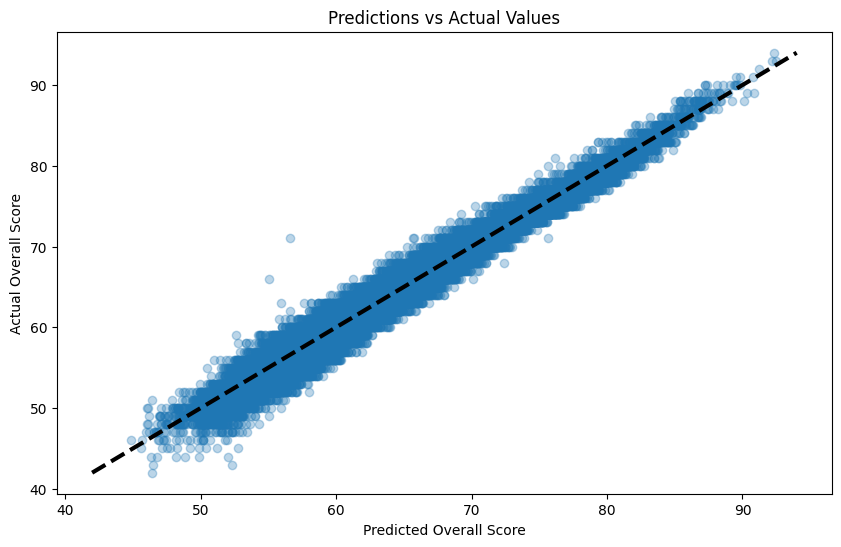

In [87]:
import matplotlib.pyplot as plt
# Collecting predictions and actual values
predicted_vs_actual = predictions.select("prediction", "overall").toPandas()


plt.figure(figsize=(10, 6))
plt.scatter(predicted_vs_actual['prediction'], predicted_vs_actual['overall'], alpha=0.3)
plt.title('Predictions vs Actual Values')
plt.xlabel('Predicted Overall Score')
plt.ylabel('Actual Overall Score')
plt.plot([predicted_vs_actual['overall'].min(), predicted_vs_actual['overall'].max()], 
         [predicted_vs_actual['overall'].min(), predicted_vs_actual['overall'].max()], 'k--', lw=3)
plt.show()

## Tuning

In [88]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LinearRegression(featuresCol='features', labelCol='overall')

lr_paramGrid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.001, 0.01, 1.0])
                .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                .addGrid(lr.maxIter, [25, 100, 250])
                .build())

evaluator = RegressionEvaluator(labelCol="overall", predictionCol="prediction", metricName="rmse")

lr_crossval = CrossValidator(estimator=lr,
                                estimatorParamMaps=lr_paramGrid,
                                evaluator=evaluator,
                                numFolds=5)

lr_cvModel = lr_crossval.fit(train)

lr_bestModel = lr_cvModel.bestModel

cv_train_pred = lr_bestModel.transform(train)
cv_train_rmse = evaluator.evaluate(cv_train_pred)

cv_test_pred = lr_bestModel.transform(test)
cv_test_rmse = evaluator.evaluate(cv_test_pred)

print(f"Best Model Train RMSE: {cv_train_rmse}")
print(f"Best Model Test RMSE: {cv_test_rmse}")

Best Model Train RMSE: 1.2819355821866885
Best Model Test RMSE: 1.276583966594367


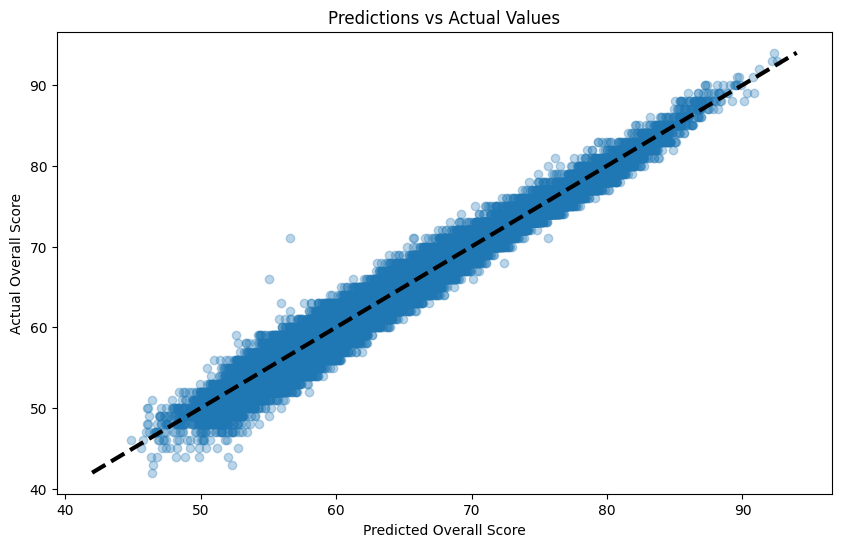

In [89]:
import matplotlib.pyplot as plt
# Collecting predictions and actual values
predicted_vs_actual = cv_test_pred.select("prediction", "overall").toPandas()


plt.figure(figsize=(10, 6))
plt.scatter(predicted_vs_actual['prediction'], predicted_vs_actual['overall'], alpha=0.3)
plt.title('Predictions vs Actual Values')
plt.xlabel('Predicted Overall Score')
plt.ylabel('Actual Overall Score')
plt.plot([predicted_vs_actual['overall'].min(), predicted_vs_actual['overall'].max()], 
         [predicted_vs_actual['overall'].min(), predicted_vs_actual['overall'].max()], 'k--', lw=3)
plt.show()

In [90]:
lr_bestModel.extractParamMap()

{Param(parent='LinearRegression_3532ef79a7bc', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LinearRegression_3532ef79a7bc', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
 Param(parent='LinearRegression_3532ef79a7bc', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35,
 Param(parent='LinearRegression_3532ef79a7bc', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LinearRegression_3532ef79a7bc', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearRegression_3532ef79a7bc', name='labelCol', doc='label column name.'): 'overall',
 Param(parent='LinearRegression_3532ef79a7bc', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber.'): 'squaredErr

## Analyze Feature Importance

In [91]:
import pandas as pd

coefficients = lr_bestModel.coefficients

feature_importance = pd.DataFrame(list(zip(feature_cols, coefficients)), columns=["Feature", "Coefficient"])

# Sort by absolute value of coefficient
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print(feature_importance[['Feature', 'Abs_Coefficient']])

remove_cols = feature_importance[feature_importance['Abs_Coefficient'] < 0.005]['Feature'].tolist()
print(f"Columns to remove: {remove_cols}")

                        Feature  Abs_Coefficient
1                           age         0.447652
43                 log_wage_eur         0.237609
0                     potential         0.223750
6                   skill_moves         0.147737
7      international_reputation         0.092950
39           preferred_foot_vec         0.066500
22           movement_reactions         0.066380
4                  league_level         0.065510
40                work_rate_vec         0.053689
41                body_type_vec         0.041256
15      attacking_short_passing         0.031599
14   attacking_heading_accuracy         0.022849
11                       physic         0.019214
37      goalkeeping_positioning         0.018777
38         goalkeeping_reflexes         0.016977
29        mentality_positioning         0.016584
35         goalkeeping_handling         0.016392
12           attacking_crossing         0.015487
5                     weak_foot         0.015063
3                   

In [92]:
feature_cols = [col for col in feature_cols if col not in remove_cols]
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_assembled = vector_assembler.transform(df_scaled)

df_factioned = df_assembled.sample(False, 0.1, seed=504)
train_reduced, test_reduced = df_assembled.randomSplit([0.7, 0.3], seed=504)

## Second Model Tuning

In [93]:
# Now we will do random forest regression
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='features', labelCol='overall')

rf_model = rf.fit(train_reduced)

train_pred = rf_model.transform(train_reduced)
test_pred = rf_model.transform(test_reduced)

evaluator = RegressionEvaluator(labelCol="overall", predictionCol="prediction", metricName="rmse")

train_rmse = evaluator.evaluate(train_pred)
test_rmse = evaluator.evaluate(test_pred)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 2.1127236663754667
Test RMSE: 2.118435319010242


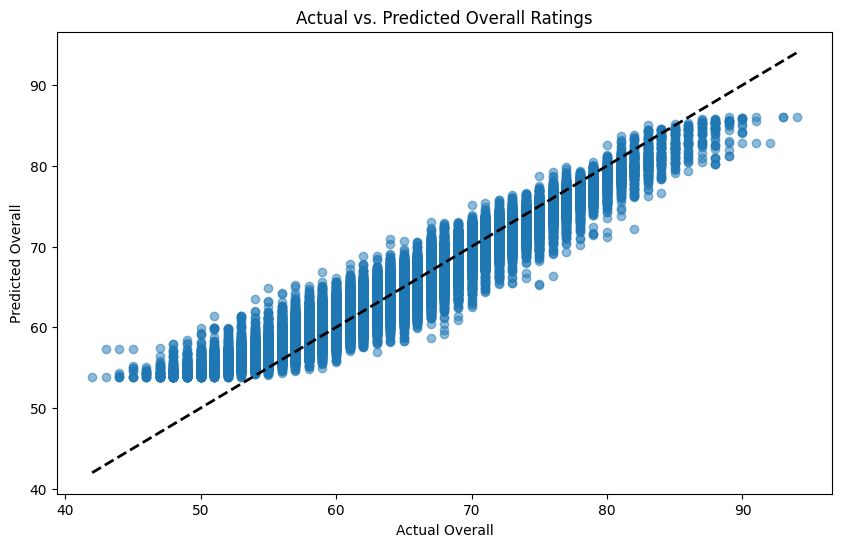

In [94]:
predictions_pd = test_pred.select('overall', 'prediction').toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['overall'], predictions_pd['prediction'], alpha=0.5)
plt.xlabel('Actual Overall')
plt.ylabel('Predicted Overall')
plt.title('Actual vs. Predicted Overall Ratings')
plt.plot([predictions_pd['overall'].min(), predictions_pd['overall'].max()], 
         [predictions_pd['overall'].min(), predictions_pd['overall'].max()], 
         'k--', lw=2)  # Diagonal line for reference
plt.show()


In [95]:
rf = RandomForestRegressor(featuresCol='features', labelCol='overall')

# Define a parameter grid to search over
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [25, 35])
             .addGrid(rf.maxDepth, [8, 10])
             .build())

# Define the evaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="overall", metricName="rmse")

# Setup CrossValidator
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
print('Stage 0: Completed!')
# Fit the model
cvModel = cv.fit(train_reduced)
print('Stage 1: Completed!')
bestmodel = cvModel.bestModel
# Make predictions and evaluate
test_pred = bestmodel.transform(test_reduced)
train_pred = bestmodel.transform(train_reduced)
train_rmse = evaluator.evaluate(train_pred)
test_rmse = evaluator.evaluate(test_pred)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Stage 0: Completed!
Stage 1: Completed!
Train RMSE: 1.2591774801821691
Test RMSE: 1.3135627968389536


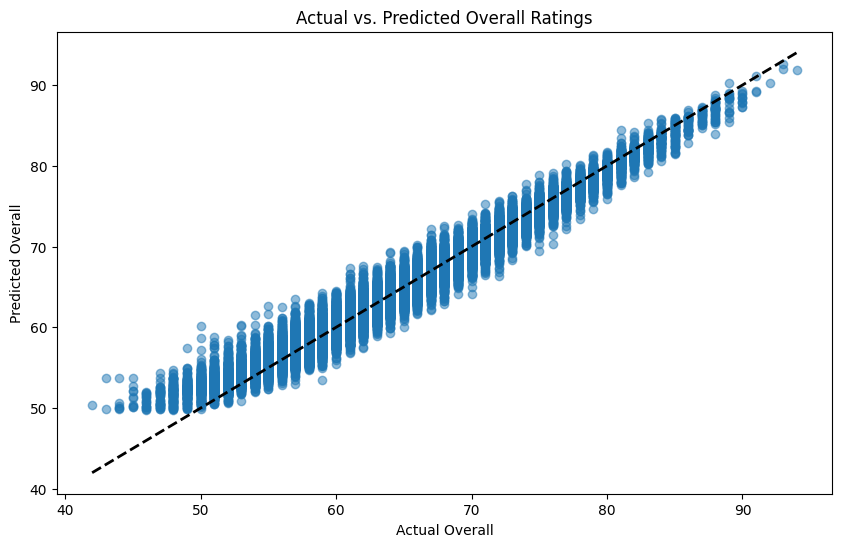

In [96]:
predictions_pd = test_pred.select('overall', 'prediction').toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['overall'], predictions_pd['prediction'], alpha=0.5)
plt.xlabel('Actual Overall')
plt.ylabel('Predicted Overall')
plt.title('Actual vs. Predicted Overall Ratings')
plt.plot([predictions_pd['overall'].min(), predictions_pd['overall'].max()], 
         [predictions_pd['overall'].min(), predictions_pd['overall'].max()], 
         'k--', lw=2)  # Diagonal line for reference
plt.show()

In [97]:
# Show best model summary
bestmodel.extractParamMap()


{Param(parent='RandomForestRegressor_0cafe58d41f4', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestRegressor_0cafe58d41f4', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestRegressor_0cafe58d41f4', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestRegressor_0cafe58d41f4', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supporte